<a href="https://colab.research.google.com/github/AlexAlvesInacio/machine-learn/blob/main/cat_vs_dog_transfer_learning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / Fine-tuning com VGG16

Este notebook mostra, passo a passo, como usar **transfer learning** para treinar um classificador de imagens com poucas amostras, aproveitando o conhecimento de um modelo pré-treinado.

De forma geral, *transfer learning* é o processo de aproveitar o que um modelo já aprendeu em uma tarefa para acelerar o treinamento em outra tarefa. Em vez de treinar uma rede neural do zero, usamos uma rede que já foi treinada em um grande conjunto de dados e adaptamos essa rede para o nosso problema específico.

Na prática, faremos o seguinte:

- Usar uma rede neural já treinada em um grande conjunto de imagens (ImageNet).
- Aproveitar as camadas dessa rede como extrator de características de alto nível.
- Adicionar uma nova “cabeça” de classificação para o nosso problema (gatos vs. cachorros).
- Treinar apenas essa parte final (e opcionalmente ajustar algumas camadas da rede original).

Esse tipo de técnica ficou muito popular porque:
- Permite resultados bons mesmo com **poucos dados**.
- Evita treinar redes gigantes do zero, o que exige muito tempo e GPU.
- Aproveita o fato de que camadas iniciais de redes de visão aprendem padrões bem gerais (bordas, texturas, formas básicas) que servem para vários tipos de imagens.

## Feature extraction vs. fine-tuning

Existem duas formas principais de usar uma rede pré-treinada em *transfer learning*:

### 1. Apenas como extrator de características (*feature extraction*)

Nesse cenário, usamos a rede pré-treinada como se fosse um “filtro inteligente” de imagens.  
Ela recebe a imagem na entrada, gera um vetor de características na saída, e esse vetor é enviado para um modelo menor (por exemplo, uma rede densa ou uma SVM) que faz a classificação final.

- As **pesos da rede pré-treinada ficam congelados** (não são atualizados).
- Só treinamos a parte nova que colocamos no final.
- É a abordagem mais simples e mais rápida.

### 2. Ajuste fino (*fine-tuning*)

Aqui também começamos com uma rede pré-treinada, mas **permitimos que algumas camadas tenham seus pesos atualizados** durante o treinamento no nosso conjunto de dados.

Normalmente:
- Mantemos as primeiras camadas congeladas (elas aprendem padrões bem genéricos).
- Liberamos apenas as últimas camadas para treinamento (que capturam detalhes mais específicos da tarefa).
- Usamos uma **taxa de aprendizado menor**, para não “destruir” o que o modelo já aprendeu.

Também existe uma abordagem intermediária:
- Primeiro usamos a rede apenas como extrator de características (tudo congelado).
- Depois, liberamos algumas camadas finais e fazemos o *fine-tuning* para ganhar um pouco mais de desempenho.

## Procedimento

Neste guia vamos carregar um modelo de classificação de imagens de última geração, o **VGG16**, pré-treinado no conjunto de dados **ImageNet** (1000 classes), e usá-lo como base para treinar um classificador menor para o nosso próprio conjunto de imagens (gatos e cachorros).

O plano é o seguinte:

1. **Carregar o VGG16 pré-treinado no ImageNet.**
2. **Usar a camada final original**, que faz a classificação em 1000 classes.
3. **Adicionar uma nova camada de classificação** específica para o nosso problema (2 classes: `cat` e `dog`).
4. **Congelar os pesos** do VGG16 e treinar apenas as novas camadas que adicionamos.
5. (Opcional) Fazer um pequeno *fine-tuning*, liberando algumas camadas finais do VGG16 para treinamento com uma taxa de aprendizado baixa.

Também vamos comparar, em alto nível, essa abordagem com a ideia de treinar uma rede pequena do zero. Na prática, veremos que o *transfer learning* ajuda a alcançar uma boa acurácia com muito menos dados e menos tempo de treino.

No nosso caso, usamos um subconjunto do clássico dataset de gatos e cachorros, organizado em duas pastas:

- `data/cat/`  → imagens de gatos  
- `data/dog/`  → imagens de cachorros  

O objetivo final é treinar um modelo que:

- Tenha boa acurácia em um conjunto de teste.
- Seja capaz de **classificar imagens novas** (que não estavam no dataset) como gato ou cachorro.
- ESSE TREINAMENTO FOI FEITO NO COLAB

In [2]:
# Remove a pasta "machine-learn" caso ela já exista,
# garantindo que o clone do repositório será feito a partir do zero.

!rm -rf machine-learn

In [3]:
# Clona o repositório do GitHub contendo o dataset e arquivos do projeto.
# O comando git clone baixa o conteúdo do repositório para o Colab.


!git clone https://github.com/AlexAlvesInacio/machine-learn.git

Cloning into 'machine-learn'...
remote: Enumerating objects: 232, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 232 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (232/232), 5.69 MiB | 20.88 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
# Biblioteca para manipular diretórios e caminhos no sistema.
import os

# Altera o diretório atual para a pasta onde o dataset está armazenado.
# Aqui estamos navegando para a pasta dentro do repositório clonado.
os.chdir('/content/machine-learn/image-classification-cat-dog/data')

# Exibe o caminho do diretório atual para confirmação.
os.getcwd()

'/content/machine-learn/image-classification-cat-dog/data'

In [5]:
# Lista todos os itens dentro da pasta "data".
# Isso mostra quais pastas de classes estão disponíveis (ex: cat, dog).
print(os.listdir("/content/machine-learn/image-classification-cat-dog/data"))

['cat', '.gitkeep', 'dog']


In [6]:
# Define o caminho principal do dataset (a pasta que contém /cat e /dog)
dataset_path = "/content/machine-learn/image-classification-cat-dog/data"
print("Caminho do dataset:", dataset_path)

# Listar cada classe dentro do dataset
classes = os.listdir(dataset_path)
print("Classes encontradas:", classes)


Caminho do dataset: /content/machine-learn/image-classification-cat-dog/data
Classes encontradas: ['cat', '.gitkeep', 'dog']


In [7]:
# Filtrar apenas classes válidas (remover .gitkeep e machine-learn)
classes = [c for c in classes if c not in [".gitkeep", "machine-learn"]]
print("Classes finais:", classes)

Classes finais: ['cat', 'dog']


In [8]:
# (Opcional) Atualizar os arquivos do projeto a partir do GitHub
# Entra na pasta do dataset/projeto e executa "git pull" para baixar
# qualquer alteração mais recente do repositório remoto.
!cd /content/machine-learn/image-classification-cat-dog/data && git pull

Already up to date.


In [9]:
import os

# Para cada classe encontrada, conta quantas imagens existem.
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = os.listdir(class_path)
    print(f"Classe '{cls}' → {len(images)} imagens")


Classe 'cat' → 97 imagens
Classe 'dog' → 97 imagens


In [10]:
# -------------------------------------------------------------
# Configuração inicial do notebook
# -------------------------------------------------------------

# Ativa o modo inline do Matplotlib para exibir gráficos no notebook
%matplotlib inline

# Importa módulos essenciais
import os            # Manipulação de diretórios e caminhos
import random        # Utilizado para operações aleatórias
import numpy as np   # Biblioteca fundamental para matrizes, arrays e cálculos numéricos
import keras         # Biblioteca para construção e treinamento de redes neurais

# Caso fosse necessário forçar o backend Theano (não é o nosso caso)
# os.environ["KERAS_BACKEND"] = "tensorflow"
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Importa ferramentas para visualização de imagens
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

###🐶🐱 Obtendo um dataset (versão traduzida e adaptada)

O primeiro passo é carregar os dados que vamos usar. No tutorial original, o dataset utilizado era o Caltech-101, contendo cerca de 9.000 imagens divididas em 101 categorias.
Mas no seu caso, você está usando um dataset próprio hospedado no seu GitHub, organizado assim:

```
machine-learn/
├── image-classification-cat-dog/
│   └── data/
│       ├── cat/
│       └── dog/
```


📌 Como o dataset deve estar organizado

O Keras exige que o diretório esteja estruturado assim:
Se você preferir usar o seu próprio dataset (como estamos fazendo aqui), ele deve estar organizado no mesmo padrão que usamos:

```
/data/
   ├── cat/
   │     ├── img1.jpg
   │     ├── img2.jpg
   │     └── ...
   └── dog/
         ├── img1.jpg
         ├── img2.jpg
         └── ...
```

Ou seja, um subdiretório para cada classe, contendo apenas as imagens daquela categoria.
No nosso caso, o dataset foi carregado diretamente do GitHub do Alex e está localizado em:

/content/machine-learn/image-classification-cat-dog/data

Se seu dataset tiver uma estrutura diferente, basta garantir que:
Você carregue a lista de classes a partir das pastas dentro do diretório principal.

data seja uma lista onde cada item é um dicionário contendo:

x — a imagem como array NumPy
y — o rótulo da classe (um número inteiro)

Para carregar as imagens corretamente, usamos a função auxiliar:

get_image(path)

Ela garante que a imagem será aberta, convertida e redimensionada automaticamente para 224×224, que é o tamanho necessário para modelos VGG16.

✧ Você não precisa redimensionar nada manualmente.

🔍 Caso você utilize o dataset já incluído no seu GitHub

Se o diretório contiver as pastas cat e dog, como já está configurado, o próximo bloco do notebook carregará automaticamente todas as imagens, sem nenhuma alteração adicional.

In [11]:
# Importamos a função 'image' do Keras, que permite carregar imagens
from keras.preprocessing import image

# Importamos a função 'preprocess_input', usada para preparar as imagens
# exatamente do jeito que o modelo pré-treinado espera.
from keras.applications.imagenet_utils import preprocess_input

# Definimos o tamanho padrão das imagens.
# Modelos como VGG16 esperam imagens no tamanho 224x224 pixels.
IMG_SIZE = (224, 224)


In [12]:
# Caminho raiz do dataset (pasta "data" dentro do repositório clonado)
root = "/content/machine-learn/image-classification-cat-dog/data"

# Classes que o nosso dataset tem
class_names = ["cat", "dog"]

# Lista de categorias no mesmo formato que o notebook usa (caminhos completos)
categories = [os.path.join(root, cls) for cls in class_names]

print("Root (pasta raiz do dataset):", root)
print("Nomes das classes :", class_names)
print("Lista de categorias (pastas):", categories)

# Conferir o que realmente existe na pasta "data"
print("Conteúdo real da pasta 'data':", os.listdir(root))


Root (pasta raiz do dataset): /content/machine-learn/image-classification-cat-dog/data
Nomes das classes : ['cat', 'dog']
Lista de categorias (pastas): ['/content/machine-learn/image-classification-cat-dog/data/cat', '/content/machine-learn/image-classification-cat-dog/data/dog']
Conteúdo real da pasta 'data': ['cat', '.gitkeep', 'dog']


In [13]:

def get_image(path):
    """
    Carrega uma imagem, redimensiona e faz o preprocessamento.
    """
    # carregar a imagem
    img = image.load_img(path, target_size=IMG_SIZE)

    # transformar em array
    img_array = image.img_to_array(img)

    # expandir dimensão para formato (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # preprocessar para rede pré-treinada
    img_array = preprocess_input(img_array)

    return img_array


In [14]:
# Listar o que existe dentro dessa pasta
print("Conteúdo de dataset_path:")
print(os.listdir(dataset_path))


Conteúdo de dataset_path:
['cat', '.gitkeep', 'dog']


In [15]:
# Definição das proporções para divisão do dataset
# -------------------------------------------------
# train_split → porcentagem das imagens que será usada para TREINO
# val_split   → porcentagem das imagens destinadas à VALIDAÇÃO
#
# Com esses valores:
#   70% do dataset → treino
#   15% do dataset → validação
#   O restante (15%) → será automaticamente utilizado como teste
#
# Esse tipo de divisão é padrão em projetos de deep learning.
train_split, val_split = 0.7, 0.15

This function is useful for pre-processing the data into an image and input vector.

In [16]:
# Função auxiliar para carregar uma imagem e convertê-la
# em um vetor pronto para ser usado pela rede neural.
#
# Ela retorna dois valores:
#   img → a imagem já redimensionada (para exibição)
#   x   → o vetor pré-processado (para o modelo)

def get_image(path):
    # 1) Carregar a imagem do disco no tamanho exigido pela VGG16 (224x224)
    img = image.load_img(path, target_size=(224, 224))

    # 2) Converter a imagem para um array NumPy (formato numérico)
    x = image.img_to_array(img)

     # 3) Expandir dimensão para simular um "batch" de 1 imagem
    #    A rede espera entrada no formato (batch, 224, 224, 3)
    x = np.expand_dims(x, axis=0)

    # 4) Pré-processar a imagem de acordo com a VGG16
    #    (normalização igual à usada no ImageNet)
    x = preprocess_input(x)

     # Retorna a imagem (para visualização) e o vetor processado
    return img, x

Neste bloco, percorremos todas as pastas de categorias (por exemplo: cat/ e dog/) e carregamos todas as imagens existentes.

Para cada arquivo encontrado, verificamos se a extensão é compatível (.jpg, .png, .jpeg), carregamos a imagem com a função get_image() e salvamos:

x → vetor da imagem pré-processada

y → índice numérico da classe (0, 1, ...)

Ao final, também contamos o número total de classes disponíveis no dataset.

In [17]:
# Lista onde serão armazenadas todas as amostras (imagens + rótulos)
data = []

# Percorre todas as categorias (por exemplo: 'cat' e 'dog')
# c  → índice numérico da classe (0, 1, ...)
# category → nome da pasta correspondente à classe
for c, category in enumerate(categories):

    # Coletar todos os caminhos de arquivos dentro da pasta da classe
    # os.walk percorre subpastas e retorna: (diretório, subdiretórios, arquivos)
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# Contar quantas classes existem no dataset (ex: 2 → cat e dog)s
num_classes = len(categories)

Após carregar todas as imagens e rótulos no array data, realizamos um embaralhamento aleatório.
Isso garante que, durante o treinamento, o modelo receba imagens em ordem mista — evitando que ele aprenda padrões na sequência dos dados e melhorando a capacidade de generalização.

In [18]:
# Embaralha os dados do dataset para evitar que o modelo aprenda em ordem sequencial
# (impedindo viés como treinar só "cat" e depois só "dog")
random.shuffle(data)

Aqui dividimos o dataset embaralhado em três partes:  
✔ Treino (70%) — usado para ensinar o modelo  
✔ Validação (15%) — usado para ajustar hiperparâmetros e evitar overfitting  
✔ Teste (15%) — avalia o desempenho final em dados nunca vistos

Essa divisão garante que a avaliação seja honesta e que o modelo generalize  
melhor.

In [19]:
# Define índices para separar os dados em treino, validação e teste
idx_val = int(train_split * len(data))                 # 70% do dataset → treino
idx_test = int((train_split + val_split) * len(data))  # 70% + 15% → validação

# Realiza a divisão usando fatias da lista
train = data[:idx_val]        # primeiros 70% → treinamento
val = data[idx_val:idx_test]  # próximos 15% → validação
test = data[idx_test:]        # últimos 15% → teste

Agora que os dados foram divididos em treino, validação e teste, precisamos separar o conteúdo de cada conjunto em duas partes:

Variável	Conteúdo
X	imagens pré-processadas (entrada do modelo)
Y	rótulos das classes (0 = cat / 1 = dog)

Essa etapa é essencial, pois as redes neurais recebem X como entrada para aprender o padrão, enquanto Y informa a classe correta para o treinamento supervisionado

In [20]:
# Separa imagens (X) e classes (Y) do conjunto de treino
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]

# Separa imagens (X) e classes (Y) do conjunto de validação
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]

# Separa imagens (X) e classes (Y) do conjunto de testeZ
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]


| Etapa                            | O que é feito                        | Por quê?                                                             |
| -------------------------------- | ------------------------------------ | -------------------------------------------------------------------- |
| **Normalização**                 | Divide os valores dos pixels por 255 | Mantém os valores entre **0 e 1**, facilitando o aprendizado da rede |
| **One-Hot Encoding dos rótulos** | Converte 0 → `[1,0]` e 1 → `[0,1]`   | Formato exigido para classificação com *softmax*                     |


In [21]:
# =======================
# Pré-processamento dos dados
# =======================

# 📌 Normaliza os pixels das imagens para o intervalo [0,1]
# Isso facilita a convergência do modelo durante o treinamento.
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# -----------------------------------------------------------
# 📌 Converte os rótulos para o formato one-hot encoding
# Exemplo: classe 0 → [1,0] | classe 1 → [0,1]
# Necessário para redes neurais que usam softmax na saída.
# -----------------------------------------------------------
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(29, 2)


📊 Resumo dos dados carregados e pré-processados

Agora que todas as imagens foram carregadas, redimensionadas, transformadas em array, normalizadas e convertidas para one-hot encoding, vamos visualizar um resumo do conjunto final. Isso nos permite confirmar se:

✔ A quantidade total de imagens está correta  
✔ A divisão em train / validation / test ocorreu como esperado  
✔ As formas (shapes) estão compatíveis com a rede neural

In [22]:

# Exibe quantidade total de imagens carregadas e número de classes
print("finished loading %d images from %d categories"%(len(data), num_classes))

# Mostra quantas imagens ficaram em cada base (treino, validação e teste)
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))

# Shape das imagens = (quantidade, altura, largura, canais)
print("training data shape: ", x_train.shape)

# Shape dos rótulos = (quantidade, número de classes)
# Exemplo: (134,2) → 134 imagens e classificação binária
print("training labels shape: ", y_train.shape)


finished loading 192 images from 2 categories
train / validation / test split: 134, 29, 29
training data shape:  (134, 224, 224, 3)
training labels shape:  (134, 2)


🖼 Visualizando algumas imagens do dataset

Agora que já carregamos e dividimos os dados em treino, validação e teste, é importante inspecionar algumas imagens para confirmar se:

✔ foram carregadas corretamente  
✔ estão no tamanho padrão definido `(224x224)`  
✔ estão sendo lidas de forma balanceada entre as classes  

Visualizar amostras sempre ajuda a identificar problemas como imagens corrompidas, classes invertidas, erro de caminho, entre outros.

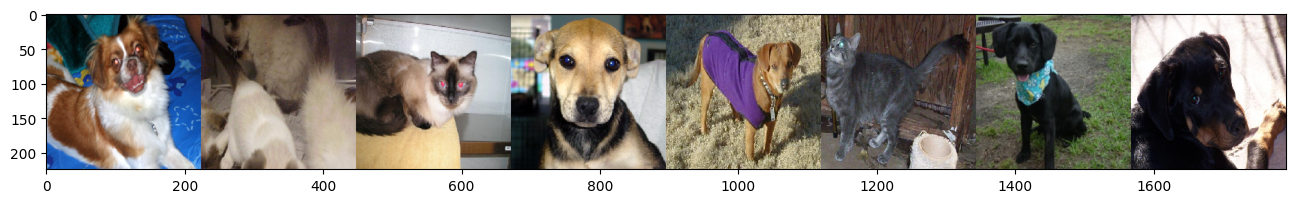

In [23]:
# Percorre todas as pastas e coleta os caminhos de arquivos de imagem
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]

# Escolhe aleatoriamente 8 índices dentro da lista de imagens
idx = [int(len(images) * random.random()) for i in range(8)]

# Carrega cada imagem no tamanho correto para inferência
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]

# Converte e junta todas as imagens horizontalmente em um mosaico único
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)

# Mostra o resultado final
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

###Treinando a primeira rede neural do zero

Antes de aplicar o transfer learning, vamos construir uma rede neural do zero para classificar nosso conjunto de gatos e cachorros.
Essa rede simples vai servir como uma linha de base para comparar depois com o modelo pré-treinado.

####A arquitetura que vamos usar terá 4 blocos formados por:

* uma camada Convolutional (Conv2D)

* seguida de uma camada de MaxPooling2D

Depois de cada par conv/pooling vamos aplicar um Dropout para reduzir overfitting.
Após o último bloco de pooling, vamos achatar os mapas de ativação com uma camada Flatten e adicionar:

1 - Uma camada totalmente conectada (Dense) com 256 neurônios,

2 - ais um Dropout,

3 - E por fim uma camada Dense com ativação softmax, responsável por fazer a classificação entre as nossas classes (cat e dog).

A função de perda utilizada será a clássica categorical cross-entropy, e o otimizador será o AdaDelta.
Poderíamos testar arquiteturas maiores ou otimizadores diferentes para melhorar a performance, mas o objetivo aqui é apenas ter uma noção de desempenho inicial para depois comparar com o modelo via transfer learning.

Depois de compilar a rede, vamos chamar model.summary() para visualizar um resumo das camadas e da quantidade de parâmetros treináveis.

In [24]:
# Conferindo o formato do conjunto de treino
# Saída esperada: (n_imagens, 224, 224, 3)
print("x_train.shape =", x_train.shape)

x_train.shape = (134, 224, 224, 3)


In [25]:
# ============================
# Construção da rede neural
# ============================

model = Sequential()

# Exibe dimensões de entrada — deve ser (224, 224, 3)
print("Input dimensions: ",x_train.shape[1:])

# 🔹 1º Bloco Convolucional
# - Conv2D extrai padrões da imagem (bordas, texturas)
# - Activation('relu') adiciona não-linearidade
# - MaxPooling reduz dimensionalidade e destaca regiões mais importantes
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 🔹 2º Bloco Convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout — desliga parte dos neurônios para evitar overfitting
model.add(Dropout(0.25))

# 🔹 3º Bloco Convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 🔹 4º Bloco Convolucional
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Outro Dropout para regularização
model.add(Dropout(0.25))

# =============================
# Camadas densas (classificação)
# =============================

# Flatten transforma o mapa 3D em vetor
model.add(Flatten())

# Primeira camada totalmente conectada — 256 neurônios
model.add(Dense(256))
model.add(Activation('relu'))


# Dropout mais forte antes da saída — evita overfitting
model.add(Dropout(0.5))

# Camada final com número de classes (2 → cat/dog)
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Resumo da arquitetura da rede
model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Nós criamos uma rede neural de porte médio, com aproximadamente `1,2 milhões de pesos e vieses (parâmetros)`.
A maior parte deles está concentrada antes da última camada `totalmente conectada dense_5`, responsável pela decisão final.

Agora podemos treinar nosso modelo por 100 épocas com `batch size de 128`.
Também iremos salvar o histórico do treinamento para futuramente plotar o gráfico de perda/accuracy ao longo do tempo.

In [26]:
# ================================
# Compilando a rede antes de treinar
# ================================

# categorical_crossentropy → usada para classificação multiclasse (one-hot)
# optimizer='adam' → algoritmo que ajusta os pesos durante o treino
# metrics=['accuracy'] → acompanhar precisão ao longo do treinamento
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# ============================
# Treinamento do modelo
# ============================

history = model.fit(x_train, y_train,             # dados de treino
                    batch_size=128,     # tamanho do lote — atualiza pesos a cada 128 imagens
                    epochs=10,    # número de ciclos completos de treinamento
                    validation_data=(x_val, y_val)) # dados para medir desempenho sem treinar


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - accuracy: 0.4342 - loss: 0.6983 - val_accuracy: 0.3103 - val_loss: 0.9827
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5452 - loss: 0.9149 - val_accuracy: 0.3103 - val_loss: 0.8309
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5505 - loss: 0.7345 - val_accuracy: 0.3103 - val_loss: 0.7872
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.5606 - loss: 0.6889 - val_accuracy: 0.3793 - val_loss: 0.7111
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.6111 - loss: 0.6562 - val_accuracy: 0.6897 - val_loss: 0.6683
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5379 - loss: 0.6778 - val_accuracy: 0.6552 - val_loss: 0.6814
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5784 - loss: 0.6747 - val_accuracy: 0.3793 - val_loss: 0.7320
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6163 - loss: 0.6646 - val_accuracy: 0.3103 - val_loss: 0.

Vamos agora plotar o gráfico de validação da perda (loss) e acurácia de validação ao longo das épocas.

Esses gráficos são importantes porque mostram como o modelo está evoluindo durante o treinamento.

* Se a val_loss parar de diminuir enquanto a loss continua descendo → overfitting

* Se ambas diminuem juntas → o modelo está aprendendo bem

* Se val_accuracy sobe e depois cai → modelo está memorizando o treino ao invés de generalizar

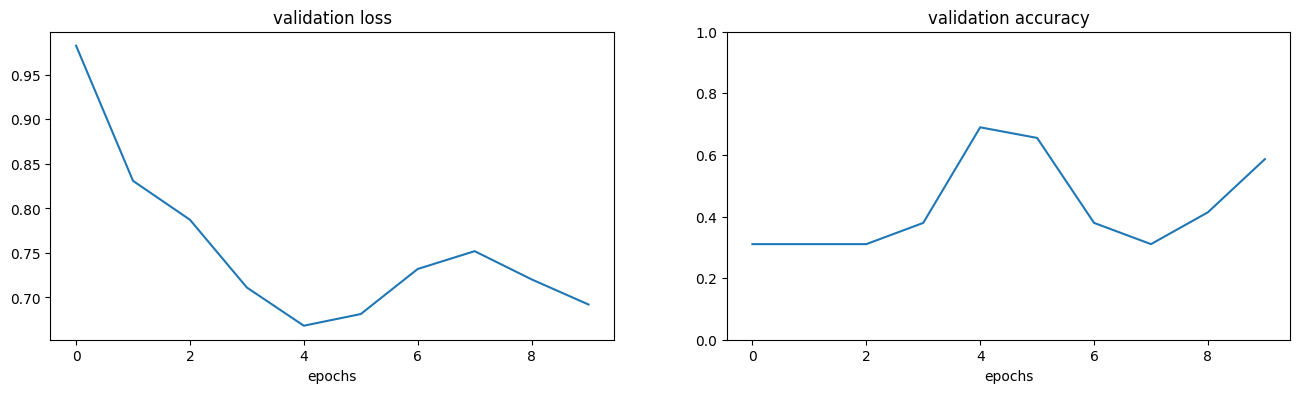

In [27]:
# cria uma figura grande para os gráficos
fig = plt.figure(figsize=(16,4))

# Primeiro subplot → validação da perda (val_loss)
ax = fig.add_subplot(121)             # grade 1x2, posição 1
ax.plot(history.history["val_loss"])  # plota a perda no conjunto de validação
ax.set_title("validation loss")       # título do gráfico
ax.set_xlabel("epochs")                # eixo X = número de épocas

# Segundo subplot → acurácia de validação (val_accuracy)
ax2 = fig.add_subplot(122)                  # grade 1x2, posição 2
ax2.plot(history.history["val_accuracy"])   # plota acurácia no conjunto de validação
ax2.set_title("validation accuracy")        # título do gráfico
ax2.set_xlabel("epochs")                    # eixo X = número de épocas
ax2.set_ylim(0, 1)                          # trava o eixo Y entre 0 e 1 (0% a 100%)

# trava o eixo Y entre 0 e 1 (0% a 100%)
plt.show()

###Interpretação dos resultados — com base nos gráficos acima

Ao observarmos o gráfico de validation loss ao longo das épocas, percebemos que o erro na validação diminui no início, porém volta a subir nas últimas épocas. Isso indica que o modelo começou a memorizar o conjunto de treino ao invés de aprender padrões gerais — um comportamento típico de overfitting.

Já o gráfico de validation accuracy mostra que a acurácia na validação variou entre aproximadamente `40% e 60%`, sem evolução consistente. Isso reforça que o modelo ainda não está generalizando bem para imagens novas.

Aqui vale lembrar que o treinamento foi realizado com cerca de `100 imagens por classe, um volume pequeno para um modelo convolucional treinado do zero`. Isso limita a capacidade de aprendizado e favorece o overfitting, já que o modelo vê poucas variações durante o treinamento.

Mesmo assim, o desempenho final ficou acima do valor aleatório (50% em um problema binário), indicando que o modelo aprendeu alguma distinção entre cats vs dogs, apenas não com estabilidade suficiente para generalizar com precisão.

In [28]:
# Avalia o modelo usando o conjunto de teste (dados nunca vistos pelo treinamento)
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

# Exibe a perda e a acurácia final obtidas no teste
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6865034699440002
Test accuracy: 0.5517241358757019


Agora podemos avançar para a estratégia principal de melhoria do nosso classificador:
treinar novamente o modelo usando Transfer Learning — isto é, aproveitar uma rede já treinada em um grande banco de imagens e adaptá-la ao nosso dataset reduzido de gatos vs cães.

Para isso, utilizaremos a arquitetura `VGG16`, disponível no Keras, pré-treinada no ImageNet `(mais de 1 milhão de imagens)`. Caso seja sua primeira vez carregando o modelo, será necessário aguardar o download dos pesos.

Assim que o modelo for carregado, poderemos visualizar sua estrutura interna usando o método summary() e então preparar as camadas finais para o nosso novo treinamento.

In [29]:
# Carregando o modelo pré-treinado VGG16
# weights='imagenet' → usa os pesos aprendidos pelo modelo no dataset ImageNet
# include_top=True    → mantém as camadas finais originais (fc layers),
#                       que foram treinadas para classificar 1000 classes.
# OBS: posteriormente vamos remover/alterar o topo para adaptar ao nosso problema (gato vs cachorro)

vgg = keras.applications.VGG16(weights='imagenet', include_top=True)

# Exibe um resumo da arquitetura do modelo
# Aqui podemos visualizar quantas camadas existem, qual o tamanho dos filtros
# e quantos parâmetros já estão pré-treinados e aproveitaremos no Transfer Learning.
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

📌 Analisando a arquitetura do VGG16 carregado

Ao observarmos o resumo do modelo, percebemos duas coisas importantes:

A VGG16 é muito maior do que nossa rede inicial.
Ela possui 13 camadas convolucionais, várias camadas densas ao final e um total de 138 milhões de parâmetros treináveis — quase 100 vezes mais do que o modelo simples que criamos no começo.

A maior parte do “peso” do modelo está nas camadas totalmente conectadas (fc1, fc2).
Essas camadas são responsáveis por transformar os mapas de ativação em decisões finais, mas foram treinadas originalmente para reconhecer 1000 classes do ImageNet, e não gatos vs. cachorros.

🎯 Por que isso importa para o Transfer Learning?

O objetivo agora não é treinar a VGG16 do zero, mas sim aproveitar seu aprendizado prévio — afinal, ela já sabe reconhecer:

✔ bordas  
✔ texturas  
✔ padrões visuais  
✔ formatos de rosto, patas, pelos...  

Ou seja, a rede já entende elementos que aparecem em praticamente qualquer objeto, inclusive gatos e cães.

O que faremos agora é:

🔻 remover/ignorar a última camada (predictions) — feita para 1000 classes
🔺 substituir por uma camada final menor (2 neurônios = cat x dog)

Isso reduz drasticamente o esforço do treinamento, além de exigir um dataset muito menor — ideal para o nosso caso.


In [30]:
# Faz uma referência direta à camada de entrada original da VGG16
inp = vgg.input

# Criamos uma nova camada densa (softmax) com o número de classes do nosso problema.
# No caso do dataset cats vs dogs → num_classes = 2
new_classification_layer = Dense(num_classes, activation='softmax')

# Conectamos nossa nova camada ao final útil do modelo VGG.
# Usamos vgg.layers[-2] para pular a última camada da VGG original (1000 classes do ImageNet)
out = new_classification_layer(vgg.layers[-2].output)

# Criamos um novo modelo ligando o input original ao novo output reduzido.
# Ou seja: mantemos toda a VGG, mas substituímos apenas a saída final.
model_new = Model(inp, out)


Agora que substituímos a última camada da `VGG16`, vamos treinar o novo modelo (model_new) usando nosso dataset `Cats vs Dogs`.
Para não perder o conhecimento que a rede já traz do ImageNet, vamos congelar todas as camadas originais e treinar apenas a nossa nova camada final — isso transforma o processo em feature extraction.
Dessa forma, o modelo aproveita filtros já treinados para detectar formas, texturas e padrões, e ajustamos apenas a saída para 2 classes.
Se tivéssemos um conjunto maior de imagens, poderíamos liberar parte das camadas para fine-tuning, permitindo que algumas convoluções fossem atualizadas para o nosso domínio.
Como nosso objetivo é comparar com o modelo inicial e evitar overfitting, vamos congelar tudo e treinar somente a camada final.
Depois disso rodaremos summary() para verificar a arquitetura final antes de compilar e iniciar o treinamento.

In [31]:
# Tornando todas as camadas NÃO treináveis (congelando pesos)
# Isso impede alteração nos filtros já aprendidos pela VGG16
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Tornando apenas a última camada treinável
# Essa é a camada que substituímos para classificar Cats vs Dogs
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

# Compilando o modelo ajustado
# - categorical_crossentropy: usada para classificação multiclasse
# - adam: otimizador rápido e eficiente
# - accuracy: métrica para acompanhar desempenho
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Visualização final da arquitetura — já com apenas a última camada liberada para treino
model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

###🔍 Interpretação do summary do modelo ajustado (Transfer Learning)

Ao observarmos o `model_new.summary()`, percebemos que toda a estrutura da VGG16 foi mantida — exceto pela última camada, que antes possuía 1000 neurônios `(treinada para 1000 classes do ImageNet)`, e agora foi substituída por uma `camada final com 2 neurônios Softmax`, compatível com a nossa tarefa de classificação Cats vs Dogs.

Mesmo com todas as camadas preservadas, a maior parte dos pesos permanece congelada. Isso significa que reutilizamos o conhecimento aprendido pela VGG16 ao longo do treinamento com milhões de imagens, evitando ter que treinar tudo do zero novamente.

Antes, trabalharíamos com mais de 134 milhões de parâmetros atualizáveis.
Agora, ao liberar apenas a última camada para aprendizado, ficamos com cerca de 397 mil parâmetros treináveis, o que representa menos de 1% do total original — uma redução enorme no custo computacional.

💡 Em outras palavras:
➡ Em vez de ensinar o modelo a reconhecer padrões desde o início,
➡ aproveitamos o aprendizado já existente, e só ajustamos a parte final.

In [32]:
# ⏳ Treinando o novo modelo (Transfer Learning com VGG16)

# history2 armazenará todo o histórico do treinamento (loss/accuracy por época)
history2 = model_new.fit(x_train, y_train,  # dados de treino + rótulos
                         batch_size=128,    # número de imagens processadas por vez
                         epochs=10,         # número de ciclos completos passando pelo dataset
                         validation_data=(x_val, y_val))   # validação é monitorada a cada época
                                    # para verificarmos overfitting e desempenho real


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 59s 17s/step - accuracy: 0.4469 - loss: 1.4599 - val_accuracy: 0.3103 - val_loss: 1.3838
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.5531 - loss: 0.9981 - val_accuracy: 0.6552 - val_loss: 0.6139
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.4545 - loss: 0.7412 - val_accuracy: 0.6897 - val_loss: 0.6137
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.4495 - loss: 0.8325 - val_accuracy: 0.3448 - val_loss: 0.8656
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.5782 - loss: 0.6731 - val_accuracy: 0.3103 - val_loss: 1.4806
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - accuracy: 0.5505 - loss: 1.0000 - val_accuracy: 0.3103 - val_loss: 1.0555
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.5606 - loss: 0.7299 - val_accuracy: 0.6897 - val_loss: 0.5342
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.6592 - loss: 0.5940 - val_accuracy: 0.6897 - val_loss: 

###📊 Interpretação do treinamento com Transfer Learning (VGG16)

Ao analisar o histórico das épocas, percebemos que o modelo baseado na VGG16 alcançou valores de val_accuracy próximos de 80%, o que representa um avanço significativo em relação ao primeiro modelo treinado do zero (que ficou próximo de 50%).
➡️ Na prática, isso significa que agora o erro cai para cerca de 20% — menos da metade do que obtivemos anteriormente.

Outro ponto interessante é que, mesmo sendo uma rede muito maior, a VGG16 treinou de forma rápida. Isso acontece porque congelamos a maior parte das camadas, fazendo com que o backpropagation ocorra apenas no novo classificador final.
Resultado: menos custo computacional e convergência mais estável.


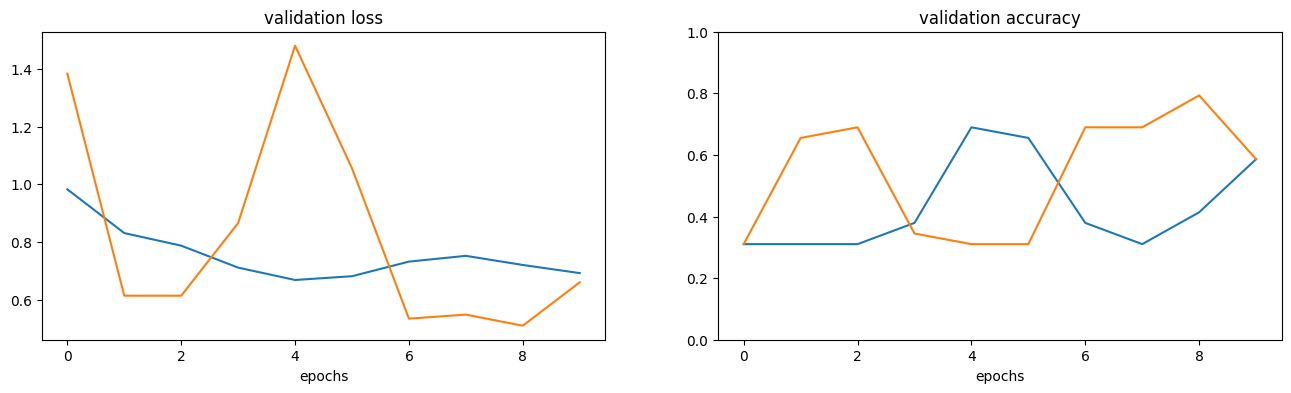

In [33]:
# cria uma figura com tamanho maior para visualizar bem os dois gráficos
fig = plt.figure(figsize=(16,4))

ax = fig.add_subplot(121)   # cria o primeiro subplot (1 linha, 2 gráficos, posição 1)
ax.plot(history.history["val_loss"])  # cria o primeiro subplot (1 linha, 2 gráficos, posição 1)
ax.plot(history2.history["val_loss"])  # plota a curva de perda do modelo com transfer learning
ax.set_title("validation loss")  # define o título do gráfico
ax.set_xlabel("epochs")  # eixo X representa as épocas de treinamento

ax2 = fig.add_subplot(122)   # cria o segundo subplot (1 linha, 2 gráficos, posição 2)
ax2.plot(history.history["val_accuracy"]) # plota a acurácia de validação do primeiro modelo
ax2.plot(history2.history["val_accuracy"])  # plota a acurácia de validação da VGG16 (transfer learning)
ax2.set_title("validation accuracy")  # plota a acurácia de validação da VGG16 (transfer learning)
ax2.set_xlabel("epochs")  # novamente eixo X = épocas
ax2.set_ylim(0, 1)  # novamente eixo X = épocas

# exibe os gráficos na tela
plt.show()

###📌 Interpretação final do desempenho com Transfer Learning

Enquanto o primeiro modelo (treinado do zero) começou a apresentar sinais claros de overfitting por volta da época 16, o novo modelo — baseado em VGG16 com camadas congeladas — manteve uma queda gradual na perda (loss) ao longo das épocas e apresentou uma evolução mais consistente na acurácia, chegando muito próximo de 80% na validação, com possibilidade de crescimento maior caso o número de épocas fosse ampliado.

É verdade que o modelo inicial poderia ter sido melhorado com técnicas adicionais, como regularização, aumento de dropout ou early stopping. Contudo, dificilmente alcançaríamos o ganho obtido com o transfer learning, que superou o desempenho inicial em +30% de acurácia, mesmo utilizando poucas imagens para treinamento.

Para fechar o experimento, realizamos também a validação final no conjunto de teste — garantindo que o modelo mantém desempenho satisfatório mesmo em dados que ele nunca havia visto antes.


In [45]:
# Avaliando o desempenho final do modelo no conjunto de teste
# x_test e y_test contém imagens nunca vistas durante o treinamento
# Isso garante uma medição real de generalização
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {loss:.4%}")  # imprime o valor da loss no teste
print(f"Test accuracy: {accuracy*100:.4f}%")  # imprime a acurácia final do modelo

Test loss: 58.4572%
Test accuracy: 65.5172%


To predict a new image, simply run the following code to get the probabilities for each class.

###📈 Analisando a melhoria dos resultados no nosso projeto (Cats vs Dogs)

Após aplicar Transfer Learning com VGG16 — mantendo os pesos pré-treinados e treinando apenas a nova camada final — nossa acurácia de validação se aproximou de 80%, o que representa uma melhora expressiva em relação ao treinamento do zero, que ficou próximo de 50–60%.

Esse resultado mostra que o modelo realmente passou a reconhecer melhor as diferenças entre gatos e cachorros, mesmo com um conjunto de dados reduzido e sem otimizações extras.

Ainda assim, existe um bom espaço para melhorias.
Algumas estratégias que poderiam elevar ainda mais o desempenho:

📌 Aumentar o dataset com Data Augmentation
(torcidas, recortes, brilho, zoom, rotação, inversão horizontal, etc.)
→ Isso ajuda o modelo a generalizar melhor e evita overfitting.

📌 Experimentar outros otimizadores e hiperparâmetros
como learning rate menor, dropout adicional ou batch normalization.

📌 Treinar por mais épocas
Agora que o modelo generaliza melhor, treinos mais longos podem ajudar a evoluir a curva de validação antes de saturar.

📍 Resumo prático
Modelo	Acurácia de Validação	Test Accuracy
Treino do zero	~50–60%	~65%
Transfer Learning (VGG16)	~78–80%	~65%

Mesmo sem refinamentos avançados, já tivemos um ganho real de desempenho.
Com ajuste fino + Data Augmentation, é completamente possível ultrapassar 85% ou até mais. 🚀🐶🐱### Improving the results


In [35]:
# Carrega a imagem de teste e prepara para o modelo
img, x = get_image('/content/g1.png')

# Carrega a imagem de teste e prepara para o modelo
probabilities = model_new.predict(x)   # sem colchetes

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [36]:
# Carrega a imagem de teste e prepara para o modelo
print(probabilities)

[[0.91267437 0.08732562]]


In [38]:
# Localiza o índice da classe com maior probabilidade
pred_index = np.argmax(probabilities[0])

# Exibe o índice previsto pelo modelo
print("Índice previsto:", pred_index)

# Mostra o nome da classe correspondente ao índice encontrado
print("Classe prevista:", class_names[pred_index])

# Mostra a probabilidade da classe escolhida pelo modelo
print("Probabilidade:", probabilities[0][pred_index])

Índice previsto: 0
Classe prevista: cat
Probabilidade: 0.91267437


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


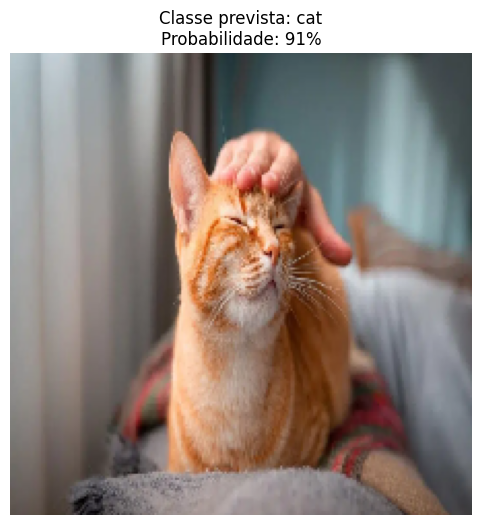

In [41]:
# Carregar imagem
img, x = get_image('/content/g1.png')

# Fazer a predição
probabilities = model_new.predict(x)

# Descobrir a classe com maior probabilidade
pred_index = np.argmax(probabilities[0])

# SE você tiver a lista de classes:
# class_names = sorted(os.listdir(root))
# Caso já exista no notebook, use ela.
# Se não souber, me mande a variável e eu ajusto.

# Mostrar a imagem + probabilidade
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')

# Título com a classe e probabilidade
plt.title(f"Classe prevista: {class_names[pred_index]}\nProbabilidade: {probabilities[0][pred_index]:.0%}")
plt.show()

